# Modellerin Performans Değerlendirilmesi

Bu notebook öncekine kıyasla sadece kaydedilmiş verisetini drive üzerinden okuyarak alır ve modelleri kullanarak test eder.

Bu çalışmada kullanılan modeller şunlardır:

1. AutoEncoder
2. Padim
3. SimpleNet

Ek olarak şunlar de denenmeye çalışılacak:

=> CRT

=>


In [ ]:
# Çalıştığın ortama göre
ENVIRONMENT = "colab" # "local"

In [1]:
if ENVIRONMENT == "colab":
    from google.colab import drive
    drive.mount('/content/drive')
    DRIVE_PATH = "/content/drive/MyDrive/Makale-Döküman-Makale Çalışmaları/YL Dersler/Makine Öğrenimi ve Anomali Tespiti/"
    PROJECT_ROOT = os.path.join(DRIVE_PATH, "Kod")
    DATASET_ROOT = os.path.join(DRIVE_PATH, "dataset")
else:
    PROJECT_ROOT = os.path.join(os.path.dirname(os.path.abspath(__file__)), "..")
    DATASET_ROOT = os.path.join(PROJECT_ROOT, "dataset")

# Orijinal olan veriler
ORIGINAL_DATA = os.path.join(DATASET_ROOT, "wood")


NameError: name 'ENVIRONMENT' is not defined

In [ ]:
SELECTED_DATASET = os.path.join(DATASET_ROOT, "wood_otsu_clahe")
TRAIN_GOOD_PATH = os.path.join(ORIGINAL_DATA, "train", "good")
TEST_GOOD_PATH = os.path.join(ORIGINAL_DATA, "test", "good")
TEST_DEFECT_PATH = os.path.join(ORIGINAL_DATA, "test", "defect")

print(f"Orijinal Dataset Path: {ORIGINAL_DATA}")
print(f"Kullanılacak Dataset Path: {SELECTED_DATASET}")

Orijinal Dataset Path: /content/drive/MyDrive/Makale-Döküman-Makale Çalışmaları/YL Dersler/Makine Öğrenimi ve Anomali Tespiti/Kod/dataset/wood
Kullanılacak Dataset Path: /content/drive/MyDrive/Makale-Döküman-Makale Çalışmaları/YL Dersler/Makine Öğrenimi ve Anomali Tespiti/Kod/dataset/wood_otsu_clahe


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from tqdm.notebook import tqdm
import shutil
from skimage import exposure
import json

# Deep Learning Kütüphaneleri
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets


from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, recall_score, roc_curve, auc

# tqdm'un pandas ile entegrasyonu için
tqdm.pandas()

### Util func.

In [ ]:

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_auc_score, f1_score, precision_score, recall_score,
    accuracy_score, confusion_matrix, roc_curve
)
import json
import pandas as pd


def load_image(image_path, target_size=(256, 256)):
    """
    Görüntü dosyasını yükler ve RGB formatına çevirir

    Args:
        image_path: Görüntü dosyasının yolu
        target_size: Hedef boyut (width, height)

    Returns:
        RGB formatında numpy array veya None
    """
    try:
        image = cv2.imread(str(image_path))
        if image is None:
            return None

        # BGR to RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image
    except Exception as e:
        print(f"Görüntü yüklenirken hata: {image_path} - {e}")
        return None


def normalize_image(image):
    """
    Görüntüyü 0-1 aralığına normalize eder

    Args:
        image: Numpy array (0-255)

    Returns:
        Normalize edilmiş görüntü (0-1)
    """
    return image.astype(np.float32) / 255.0


def preprocess_for_anomaly_detection(image, target_size=(256, 256)):
    """
    Anomali tespiti için görüntü ön işleme

    Args:
        image: RGB görüntü
        target_size: Hedef boyut

    Returns:
        Normalize edilmiş ve resize edilmiş görüntü
    """
    # Resize
    if image.shape[:2] != target_size:
        image = cv2.resize(image, target_size, interpolation=cv2.INTER_LANCZOS4)

    # Normalize (0-1)
    image = normalize_image(image)

    return image


def create_anomaly_map(original, reconstructed):
    """
    Orijinal ve yeniden oluşturulmuş görüntüler arasındaki farkı hesaplar

    Args:
        original: Orijinal görüntü
        reconstructed: Yeniden oluşturulmuş görüntü

    Returns:
        Anomali haritası
    """
    # MSE hesapla (her piksel için)
    diff = np.mean(np.square(original - reconstructed), axis=-1)

    # Normalize et
    diff = (diff - diff.min()) / (diff.max() - diff.min() + 1e-8)

    return diff


def calculate_metrics(y_true, y_scores, threshold=0.5):
    """
    Sınıflandırma metriklerini hesaplar

    Args:
        y_true: Gerçek etiketler (0: normal, 1: anomaly)
        y_scores: Anomali skorları (0-1 arası)
        threshold: Karar eşiği

    Returns:
        Metrik sözlüğü
    """
    # Binary predictions
    y_pred = (y_scores >= threshold).astype(int)

    # Metrikler
    results = {
        'auc_score': roc_auc_score(y_true, y_scores),
        'f1_score': f1_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0),
        'accuracy': accuracy_score(y_true, y_pred),
        'confusion_matrix': confusion_matrix(y_true, y_pred).tolist(),
        'threshold': threshold,
        'y_scores': y_scores.tolist() if isinstance(y_scores, np.ndarray) else y_scores,
        'y_true': y_true.tolist() if isinstance(y_true, np.ndarray) else y_true
    }

    return results


def plot_metrics(results, model_name="Model"):
    """
    Metrik sonuçlarını görselleştirir

    Args:
        results: calculate_metrics fonksiyonundan dönen sözlük
        model_name: Model adı
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Confusion Matrix
    cm = np.array(results['confusion_matrix'])
    axes[0].imshow(cm, cmap='Blues', interpolation='nearest')
    axes[0].set_title(f'{model_name} - Confusion Matrix')
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('Actual')

    # Değerleri yazdır
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            axes[0].text(j, i, str(cm[i, j]),
                        ha='center', va='center', color='red')

    # ROC Curve
    y_true = np.array(results['y_true'])
    y_scores = np.array(results['y_scores'])
    fpr, tpr, _ = roc_curve(y_true, y_scores)

    axes[1].plot(fpr, tpr, label=f'AUC = {results["auc_score"]:.4f}')
    axes[1].plot([0, 1], [0, 1], 'k--', label='Random')
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].set_title(f'{model_name} - ROC Curve')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Metrikleri yazdır
    print(f"\n=== {model_name} PERFORMANS METRİKLERİ ===")
    print(f"AUC Score:    {results['auc_score']:.4f}")
    print(f"F1 Score:     {results['f1_score']:.4f}")
    print(f"Precision:    {results['precision']:.4f}")
    print(f"Recall:       {results['recall']:.4f}")
    print(f"Accuracy:     {results['accuracy']:.4f}")
    print(f"Threshold:    {results['threshold']:.4f}")
    print("="*45)


def visualize_anomaly_detection(images, labels, scores, anomaly_maps,
                                model_name="Model", num_samples=6):
    """
    Anomali tespit sonuçlarını görselleştirir

    Args:
        images: Test görüntüleri
        labels: Gerçek etiketler
        scores: Anomali skorları
        anomaly_maps: Anomali haritaları
        model_name: Model adı
        num_samples: Gösterilecek örnek sayısı
    """
    # Her sınıftan eşit sayıda örnek seç
    normal_indices = np.where(labels == 0)[0]
    anomaly_indices = np.where(labels == 1)[0]

    n_per_class = num_samples // 2

    selected_indices = []
    if len(normal_indices) > 0:
        selected_indices.extend(np.random.choice(normal_indices,
                                                min(n_per_class, len(normal_indices)),
                                                replace=False))
    if len(anomaly_indices) > 0:
        selected_indices.extend(np.random.choice(anomaly_indices,
                                                 min(n_per_class, len(anomaly_indices)),
                                                 replace=False))

    n_samples = len(selected_indices)
    fig, axes = plt.subplots(n_samples, 2, figsize=(8, 3*n_samples))

    if n_samples == 1:
        axes = axes.reshape(1, -1)

    for idx, img_idx in enumerate(selected_indices):
        # Orijinal görüntü
        axes[idx, 0].imshow(images[img_idx])
        label_text = "Normal" if labels[img_idx] == 0 else "Anomaly"
        axes[idx, 0].set_title(f'{label_text} | Score: {scores[img_idx]:.3f}')
        axes[idx, 0].axis('off')

        # Anomaly map
        axes[idx, 1].imshow(anomaly_maps[img_idx], cmap='jet')
        axes[idx, 1].set_title('Anomaly Map')
        axes[idx, 1].axis('off')

    plt.suptitle(f'{model_name} - Anomaly Detection Results', fontsize=14)
    plt.tight_layout()
    plt.show()


def save_model_results(model_name, results, output_dir="results"):
    """
    Model sonuçlarını dosyaya kaydeder

    Args:
        model_name: Model adı
        results: Metrik sonuçları
        output_dir: Çıktı dizini
    """
    os.makedirs(output_dir, exist_ok=True)

    # JSON olarak kaydet
    output_file = os.path.join(output_dir, f"{model_name}_results.json")

    # Numpy array'leri liste'ye çevir
    results_copy = results.copy()

    with open(output_file, 'w') as f:
        json.dump(results_copy, f, indent=4)

    print(f"\n✅ Sonuçlar kaydedildi: {output_file}")


def compare_models(results_list, model_names):
    """
    Birden fazla modelin performansını karşılaştırır

    Args:
        results_list: Model sonuçları listesi
        model_names: Model isimleri listesi
    """
    metrics_to_compare = ['auc_score', 'f1_score', 'precision', 'recall', 'accuracy']

    # DataFrame oluştur
    comparison_data = []
    for model_name, results in zip(model_names, results_list):
        row = {'Model': model_name}
        for metric in metrics_to_compare:
            row[metric] = results.get(metric, 0)
        comparison_data.append(row)

    df = pd.DataFrame(comparison_data)

    # Görselleştirme
    fig, axes = plt.subplots(1, len(metrics_to_compare), figsize=(18, 4))

    for idx, metric in enumerate(metrics_to_compare):
        axes[idx].bar(df['Model'], df[metric])
        axes[idx].set_title(metric.replace('_', ' ').title())
        axes[idx].set_ylim(0, 1)
        axes[idx].grid(True, alpha=0.3)
        axes[idx].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

    # Tablo yazdır
    print("\n=== MODEL KARŞILAŞTIRMA TABLOSU ===")
    print(df.to_string(index=False))
    print("="*60)

    return df

import torch
import numpy as np
import matplotlib.pyplot as plt

def visualize_reconstructions(
    model,
    dataset,
    device,
    num_samples=5,
    is_anomaly=False,
    title_prefix=""
):
    """
    AutoEncoder reconstruction görselleştirme
    - Train için: is_anomaly=False
    - Test için anomaly görmek istiyorsan: is_anomaly=True
    """

    model.eval()

    # Dataset içinden index seç
    indices = []

    if hasattr(dataset, "labels") and dataset.labels is not None:
        # Test dataset
        labels = np.array(dataset.labels)
        target_label = 1 if is_anomaly else 0
        indices = np.where(labels == target_label)[0]
    else:
        # Train dataset (sadece good vardır)
        indices = np.arange(len(dataset))

    if len(indices) == 0:
        print("Seçilen sınıfa ait örnek yok.")
        return

    selected_indices = np.random.choice(
        indices,
        size=min(num_samples, len(indices)),
        replace=False
    )

    fig, axes = plt.subplots(
        len(selected_indices),
        3,
        figsize=(12, 4 * len(selected_indices))
    )

    if len(selected_indices) == 1:
        axes = axes.reshape(1, -1)

    with torch.no_grad():
        for i, idx in enumerate(selected_indices):

            sample = dataset[idx]

            if isinstance(sample, tuple):
                image = sample[0]
            else:
                image = sample

            image = image.unsqueeze(0).to(device)

            # Reconstruction
            recon = model(image)

            # Error map (MAE)
            error_map = torch.mean(
                torch.abs(recon - image),
                dim=1
            )

            # Tensor → numpy
            original_np = image.squeeze(0).permute(1, 2, 0).cpu().numpy()
            recon_np = recon.squeeze(0).permute(1, 2, 0).cpu().numpy()
            error_np = error_map.squeeze(0).cpu().numpy()

            # 0–1 aralığında göster
            original_np = np.clip(original_np, 0, 1)
            recon_np = np.clip(recon_np, 0, 1)

            # Plot
            axes[i, 0].imshow(original_np)
            axes[i, 0].set_title(f"Original {title_prefix}")
            axes[i, 0].axis("off")

            axes[i, 1].imshow(recon_np)
            axes[i, 1].set_title("Reconstructed")
            axes[i, 1].axis("off")

            axes[i, 2].imshow(error_np, cmap="hot")
            axes[i, 2].set_title(f"Error Map (mean={error_np.mean():.4f})")
            axes[i, 2].axis("off")

    plt.tight_layout()
    plt.show()


In [ ]:

def load_dataset(data_dir, target_size=(256, 256)):
    """Dataset'i yükle ve hazırla"""
    train_good_dir = os.path.join(data_dir, "train", "good")
    test_good_dir = os.path.join(data_dir, "test", "good")
    test_defect_dir = os.path.join(data_dir, "test", "defect")

    # Training verisi (sadece good örnekler)
    train_images = []
    train_files = [f for f in os.listdir(train_good_dir) if f.endswith('.bmp')]

    print(f"Training verisi yükleniyor: {len(train_files)} dosya...")
    for filename in train_files:
        img_path = os.path.join(train_good_dir, filename)
        img = load_image(img_path, target_size)
        if img is not None:
            img = preprocess_for_anomaly_detection(img, target_size)
            train_images.append(img)

    # Test verisi (good + defect)
    test_images = []
    test_labels = []

    # Good örnekler
    test_good_files = [f for f in os.listdir(test_good_dir) if f.endswith('.bmp')]
    print(f"Test good verisi yükleniyor: {len(test_good_files)} dosya...")
    for filename in test_good_files:
        img_path = os.path.join(test_good_dir, filename)
        img = load_image(img_path, target_size)
        if img is not None:
            img = preprocess_for_anomaly_detection(img, target_size)
            test_images.append(img)
            test_labels.append(0)  # 0 = normal

    # Defect örnekler
    test_defect_files = [f for f in os.listdir(test_defect_dir) if f.endswith('.bmp')]
    print(f"Test defect verisi yükleniyor: {len(test_defect_files)} dosya...")
    for filename in test_defect_files:
        img_path = os.path.join(test_defect_dir, filename)
        img = load_image(img_path, target_size)
        if img is not None:
            img = preprocess_for_anomaly_detection(img, target_size)
            test_images.append(img)
            test_labels.append(1)  # 1 = anomaly

    return np.array(train_images), np.array(test_images), np.array(test_labels)


In [ ]:
# Autoencoder modelini ve loader fonksiyonunu içe aktar
print('Modül yüklendi: model1_autoencoder')

# Dataseti yükle (modelin sağladığı loader ile)
target_size = (256, 256)
train_images, test_images, test_labels = load_dataset(SELECTED_DATASET, target_size)

print('\nDataset Bilgileri:')
print('Training set:', train_images.shape)
print('Test set    :', test_images.shape)
print('Test labels :', test_labels.shape)
print('Normal samples:', int(np.sum(test_labels == 0)))
print('Anomaly samples:', int(np.sum(test_labels == 1)))

Modül yüklendi: model1_autoencoder
Training verisi yükleniyor: 90 dosya...
Test good verisi yükleniyor: 10 dosya...
Test defect verisi yükleniyor: 36 dosya...

Dataset Bilgileri:
Training set: (90, 256, 256, 3)
Test set    : (46, 256, 256, 3)
Test labels : (46,)
Normal samples: 10
Anomaly samples: 36


In [ ]:
class WoodDataset(Dataset):
    def __init__(self, images, labels=None):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = torch.tensor(
            self.images[idx], dtype=torch.float32
        ).permute(2, 0, 1)

        if self.labels is None:
            return img          # train
        else:
            return img, self.labels[idx]  # test


In [ ]:
train_dataset = WoodDataset(train_images)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = WoodDataset(test_images, test_labels)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)




## Implement AutoEncoder Model


In [ ]:
import torch.nn as nn

class AutoEncoder(nn.Module):
    def __init__(self, in_channels=3, latent_dim=128):
        super(AutoEncoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=4, stride=2, padding=1), # Output: 32x128x128
            nn.ReLU(True),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1), # Output: 64x64x64
            nn.ReLU(True),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1), # Output: 128x32x32
            nn.ReLU(True),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1), # Output: 256x16x16
            nn.ReLU(True),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, latent_dim, kernel_size=4, stride=2, padding=1), # Output: latent_dim x 8 x 8
            nn.ReLU(True),
            nn.BatchNorm2d(latent_dim)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 256, kernel_size=4, stride=2, padding=1), # Output: 256x16x16
            nn.ReLU(True),
            nn.BatchNorm2d(256),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1), # Output: 128x32x32
            nn.ReLU(True),
            nn.BatchNorm2d(128),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1), # Output: 64x64x64
            nn.ReLU(True),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1), # Output: 32x128x128
            nn.ReLU(True),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32, in_channels, kernel_size=4, stride=2, padding=1), # Output: in_channelsx256x256
            nn.Sigmoid() # Output pixels in [0, 1] range for image reconstruction
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

print("AutoEncoder model defined.")

AutoEncoder model defined.


## SimpleNet Modelini Uygula

Anomali tespiti için SimpleNet mimarisini PyTorch'ta tanımlayın. Bu modelin, sınıflandırma veya özellik çıkarımı için uygun katmanları içermesi gerekmektedir.


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleNet(nn.Module):
    def __init__(self, in_channels=3, latent_dim=256):
        super(SimpleNet, self).__init__()
        self.backbone = backbone
        self.head = nn.Linear(latent_dim, 1)  # binary

        # Convolutional layers
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(in_channels, 32, kernel_size=3, padding=1), # 32x256x256
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 32x128x128

            # Block 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1), # 64x128x128
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 64x64x64

            # Block 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1), # 128x64x64
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 128x32x32

            # Block 4
            nn.Conv2d(128, 256, kernel_size=3, padding=1), # 256x32x32
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)  # 256x16x16
        )

        # Calculate the size of the flattened features
        # For an input of 256x256, after 4 MaxPool2d(k=2,s=2) layers, the spatial size becomes 256 / (2^4) = 256 / 16 = 16
        # And the last conv layer outputs 256 channels
        self.flat_features_size = 256 * 16 * 16 # 256 channels * 16x16 spatial dimensions

        # Fully connected layer for feature extraction
        self.classifier = nn.Sequential(
            nn.Linear(self.flat_features_size, latent_dim),
            nn.ReLU(inplace=True) # Output a feature vector
            # If it were for classification, a final nn.Linear(latent_dim, num_classes) would follow, possibly with a softmax/sigmoid
        )

    def forward(self, x):
        feats = self.backbone(x)          # [B, latent_dim]
        logits = self.head(feats).squeeze(1)  # [B]
        return logits

print("SimpleNet model architecture defined.")

SimpleNet model architecture defined.


----

## Train AutoEncoder


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Instantiate the AutoEncoder model
# Assuming input images are RGB (3 channels) and TARGET_IMAGE_SIZE is used for output
model = AutoEncoder(in_channels=3, latent_dim=128).to(device)
print("AutoEncoder model instantiated and moved to device.")

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
print("Loss function (MSE) and optimizer (Adam) defined.")

NUM_EPOCHS = 20

# Training loop
print("Starting AutoEncoder training...")
model.train() # Set the model to training mode

for epoch in range(NUM_EPOCHS):
    running_loss = 0.0
    num_samples = 0

    for images in train_loader:   # ← SADECE images
        images = images.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, images)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        num_samples += images.size(0)

    epoch_loss = running_loss / num_samples
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Loss: {epoch_loss:.4f}")


print("AutoEncoder training complete.")

Using device: cuda
AutoEncoder model instantiated and moved to device.
Loss function (MSE) and optimizer (Adam) defined.
Starting AutoEncoder training...
Epoch [1/20], Loss: 0.0636
Epoch [2/20], Loss: 0.0467
Epoch [3/20], Loss: 0.0443
Epoch [4/20], Loss: 0.0421
Epoch [5/20], Loss: 0.0396
Epoch [6/20], Loss: 0.0374
Epoch [7/20], Loss: 0.0354
Epoch [8/20], Loss: 0.0333
Epoch [9/20], Loss: 0.0309
Epoch [10/20], Loss: 0.0279
Epoch [11/20], Loss: 0.0268
Epoch [12/20], Loss: 0.0248
Epoch [13/20], Loss: 0.0246
Epoch [14/20], Loss: 0.0239
Epoch [15/20], Loss: 0.0220
Epoch [16/20], Loss: 0.0221
Epoch [17/20], Loss: 0.0210
Epoch [18/20], Loss: 0.0215
Epoch [19/20], Loss: 0.0210
Epoch [20/20], Loss: 0.0204
AutoEncoder training complete.


In [ ]:

# 1. Modeli değerlendirme moduna alın
model.eval()

# Rekonstrüksiyon hatalarını ve gerçek etiketleri depolamak için listeler
reconstruction_errors = []
true_labels = []

# 2. Test veri setindeki tüm görüntüleri modelden geçirin
with torch.no_grad():
    for images, labels in test_loader:
        # Skip if the batch is empty
        if images is None or labels is None:
            continue

        images = images.to(device)

        # Forward pass (reconstruction)
        outputs = model(images)

        # Rekonstrüksiyon hatasını hesapla (MSE)
        # Her bir resim için hata hesaplamak adına reduction='none' kullan
        batch_errors = torch.mean((outputs - images)**2, dim=[1,2,3])
        reconstruction_errors.extend(batch_errors.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

print("Rekonstrüksiyon hataları ve gerçek etiketler toplandı.")

# Sonuçları NumPy dizilerine dönüştür
reconstruction_errors = np.array(reconstruction_errors)
true_labels = np.array(true_labels)

print(f"Toplam rekons. hatası sayısı: {len(reconstruction_errors)}")
print(f"Toplam gerçek etiket sayısı: {len(true_labels)}")


Rekonstrüksiyon hataları ve gerçek etiketler toplandı.
Toplam rekons. hatası sayısı: 46
Toplam gerçek etiket sayısı: 46


In [ ]:


# numpy'a çevir ve 1D yap
y_true = np.asarray(true_labels).astype(int).ravel()
scores = np.asarray(reconstruction_errors).astype(float).ravel()

# Güvenlik: iki sınıf var mı?
uniq = np.unique(y_true)
if uniq.size != 2:
    raise ValueError(f"ROC için y_true iki sınıf içermeli (0 ve 1). Şu an: {uniq}")

# Skor yönü kontrolü: "yüksek skor = anomali" mi, yoksa tersi mi?
# İki yön için AUC hesapla ve daha iyi olanı seç
fpr1, tpr1, thr1 = roc_curve(y_true, scores)          # yüksek = pozitif (anomaly)
auc1 = auc(fpr1, tpr1)

fpr2, tpr2, thr2 = roc_curve(y_true, -scores)         # düşük = pozitif (anomaly) durumunu yakalar
auc2 = auc(fpr2, tpr2)

if auc2 > auc1:
    used_scores = -scores
    fpr, tpr, thresholds = fpr2, tpr2, thr2
    direction = "(-reconstruction_errors) kullanıldı (düşük skor = anomali varsayımı daha iyi çıktı)"
else:
    used_scores = scores
    fpr, tpr, thresholds = fpr1, tpr1, thr1
    direction = "(reconstruction_errors) kullanıldı (yüksek skor = anomali)"

# Youden's J: tpr - fpr maksimum
optimal_idx = int(np.argmax(tpr - fpr))
anomaly_threshold = float(thresholds[optimal_idx])

print(direction)
print(f"AUC (chosen): {max(auc1, auc2):.4f}")
print(f"Optimal Anomaly Threshold (based on ROC / Youden J): {anomaly_threshold:.6f}")

# Eşik ile sınıflandırma (pozitif=1)
predicted_labels = (used_scores >= anomaly_threshold).astype(int)

# Sayım (0 ve 1 her zaman görünsün)
pred_counts = np.bincount(predicted_labels, minlength=2)
true_counts = np.bincount(y_true, minlength=2)

print(f"Predicted labels count (0=normal, 1=anomaly): {pred_counts}")
print(f"True labels count (0=normal, 1=anomaly): {true_counts}")


(reconstruction_errors) kullanıldı (yüksek skor = anomali)
AUC (chosen): 0.6583
Optimal Anomaly Threshold (based on ROC / Youden J): 0.015774
Predicted labels count (0=normal, 1=anomaly): [ 5 41]
True labels count (0=normal, 1=anomaly): [10 36]



--- Model Performans Metrikleri ---
Accuracy: 0.8913
F1-Score: 0.9351
Recall: 1.0000

Karışıklık Matrisi:
[[ 5  5]
 [ 0 36]]


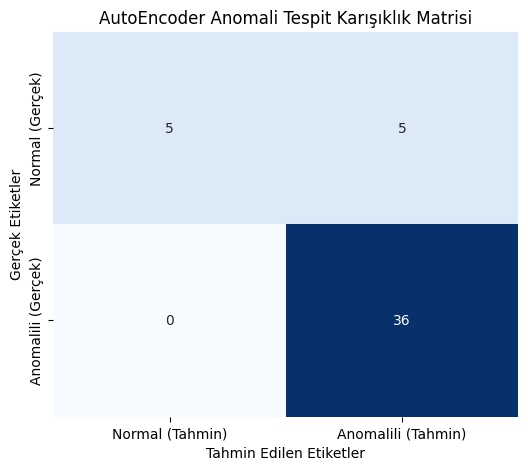

In [ ]:
print("\n--- Model Performans Metrikleri ---")

# Performans metriklerini hesapla
accuracy = accuracy_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Recall: {recall:.4f}")

# Karışıklık Matrisini oluştur
cm = confusion_matrix(true_labels, predicted_labels)
print("\nKarışıklık Matrisi:")
print(cm)

# Karışıklık Matrisini görselleştir
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Normal (Tahmin)', 'Anomalili (Tahmin)'],
            yticklabels=['Normal (Gerçek)', 'Anomalili (Gerçek)'])
plt.title('AutoEncoder Anomali Tespit Karışıklık Matrisi')
plt.xlabel('Tahmin Edilen Etiketler')
plt.ylabel('Gerçek Etiketler')
plt.show()

In [ ]:
print("Visualizing TEST (Good samples)")
visualize_reconstructions(
    model,
    test_dataset,
    device,
    num_samples=3,
    is_anomaly=False,
    title_prefix="Test / Good"
)


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
print("Visualizing TEST (Defect samples)")
visualize_reconstructions(
    model,
    test_dataset,
    device,
    num_samples=3,
    is_anomaly=True,
    title_prefix="Test / Defect"
)


Output hidden; open in https://colab.research.google.com to view.

## Train SimpleNet

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

backbone = SimpleNet(in_channels=3, latent_dim=256).to(device)
model = SimpleNet(backbone, latent_dim=256).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


TypeError: unsupported operand type(s) for %: 'SimpleNet' and 'int'

In [ ]:
NUM_EPOCHS = 15

for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_dataloader:
        images = images.to(device)
        labels = labels.float().to(device)

        optimizer.zero_grad()

        logits = model(images)
        loss = criterion(logits, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

        preds = (torch.sigmoid(logits) >= 0.5).int()
        correct += (preds == labels.int()).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total

    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] "
          f"Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.4f}")


In [ ]:
import numpy as np
from sklearn.metrics import (
    confusion_matrix, accuracy_score,
    f1_score, recall_score, roc_curve, auc
)

model.eval()
all_scores = []
all_labels = []

with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to(device)

        logits = model(images)
        scores = torch.sigmoid(logits)  # anomaly probability

        all_scores.extend(scores.cpu().numpy())
        all_labels.extend(labels.numpy())

all_scores = np.array(all_scores)
all_labels = np.array(all_labels)


## Basitleştirilmiş PatchCore Yaklaşımını Anlat

### Subtask:
PatchCore anomali tespit yönteminin temel prensiplerini ve basitleştirilmiş bir uygulamasının nasıl yapılabileceğini açıklayın. Bu, görüntü yamalarının nasıl çıkarılacağı, bir özellik uzayında nasıl temsil edileceği ve anormallik skorlarının nasıl hesaplanacağı hakkında kavramsal bir genel bakış içerecektir.

### PatchCore Yaklaşımının Genel Amacı ve Anomali Tespitindeki Rolü
PatchCore, özellikle görsel anomali tespiti (Visual Anomaly Detection) alanında yüksek performans gösteren bir tek sınıflı (one-class) sınıflandırma yöntemidir. Amacı, yalnızca 'normal' veriler üzerinde eğitilerek, daha sonra karşılaşılan görüntülerin normal mi yoksa anomali mi olduğunu etkili bir şekilde belirlemektir. Endüstriyel denetim, tıbbi görüntüleme ve kalite kontrol gibi alanlarda, anomali örneklerinin azlığı veya çeşitliliği nedeniyle geleneksel sınıflandırma yöntemlerinin yetersiz kaldığı durumlarda büyük önem taşır.

### Görüntü Yamalarının (Image Patches) Çıkarılması
PatchCore'un temel fikri, bir görüntüyü bütün olarak analiz etmek yerine, onu küçük, örtüşen parçalara (patch'ler) ayırarak her bir yamanın özelliklerini incelemektir. Bu yamalar, genellikle görüntünün farklı bölgelerindeki lokal dokuları, kenarları ve desenleri yakalar. Anomali tespiti için önemlidir, çünkü anomaliler genellikle görüntünün sadece belirli bölgelerinde (örneğin, bir yüzeydeki çatlak veya çizik) ortaya çıkar. Görüntüyü yamalara bölerek model, anomalinin tam olarak nerede olduğunu ve neye benzediğini daha hassas bir şekilde belirleyebilir.

### Özellik Uzayında Temsil Edilme ve Özellik Öğrenimi
Çıkarılan her bir görüntü yaması, önceden eğitilmiş derin bir Evrişimsel Sinir Ağı (CNN) (örneğin, ResNet gibi bir omurga ağı) kullanılarak bir özellik vektörüne dönüştürülür. Bu CNN'ler genellikle büyük ölçekli görüntü sınıflandırma görevlerinde (ImageNet gibi) eğitilmiş olup, genel görüntü özelliklerini çıkarma konusunda oldukça etkilidirler. Her yama için elde edilen bu özellik vektörleri, görüntünün anlamsal içeriğini ve dokusal bilgilerini yoğunlaştırılmış bir biçimde temsil eder. Bu özellikler, yüksek boyutlu bir 'özellik uzayında' yer alır.

### Normal Dağılımın Oluşturulması ve Sapmaların Değerlendirilmesi
Eğitim aşamasında, yalnızca 'normal' kabul edilen görüntüler kullanılır. Bu normal görüntülerden çıkarılan tüm yama özellik vektörleri toplanır ve bu özellik uzayında bir 'bellek bankası' (memory bank) veya 'çekirdek kümesi' (coreset) oluşturulur. Bu bellek bankası, normal veri dağılımının bir temsilini sağlar. Amacı, normal görüntülerdeki çeşitli doku ve desenleri kapsayan, ancak aynı zamanda gereksiz tekrarı azaltan temsili bir özellik kümesi oluşturmaktır. Test aşamasında, bir görüntünün yamalarından çıkarılan özellikler bu bellek bankasındaki en yakın normal yamalarla karşılaştırılır. Bu karşılaştırma, öklid mesafesi veya diğer benzerlik ölçütleri ile yapılır.

### Anormallik Skorlarının Hesaplanması
Bir test görüntüsü verildiğinde:
1. Görüntü, yamalara ayrılır.
2. Her bir yama, önceden eğitilmiş modelden bir özellik vektörü olarak çıkarılır.
3. Her bir yama özelliği vektörü için, bellek bankasındaki (normal örneklerden oluşturulan) en yakın komşu (k-NN) veya komşular bulunur.
4. Bu en yakın komşuya olan mesafe, o yamanın 'anormallik skoru' olarak kabul edilir. Mesafe ne kadar büyükse, yama o kadar anomalidir.
5. Görüntünün genel anormallik skoru ise, genellikle görüntüyü oluşturan yamalardan elde edilen en yüksek (maksimum) anormallik skorudur. Bu, anomali genellikle görüntünün sadece küçük bir bölümünü etkilediği için mantıklıdır.

Sonuç olarak, yüksek anormallik skoruna sahip bir görüntü veya görüntü bölgesi, modelin eğitimde görmediği 'normal' kalıplardan önemli ölçüde sapan bir durum olarak işaretlenir. Bu basit ama etkili yaklaşım, anomalilerin lokal doğasından yararlanarak başarılı sonuçlar elde edilmesini sağlar.

## Padim Yaklaşımını Anlat

### Subtask:
Padim anomali tespit yönteminin temel prensiplerini ve uygulamasının nasıl yapılabileceğini açıklayın. Bu, çok ölçekli özellik çıkarma, Gaussian dağılımı ile normalleştirme ve anormallik skorlarının nasıl hesaplanacağı hakkında kavramsal bir genel bakış içerecektir.

### Padim: Anomali Tespiti İçin Çok Ölçekli Bir Yaklaşım

Padim (PAtch Dİstribution Modeling), özellikle görüntü verilerinde anomali tespiti için geliştirilmiş, tek sınıflı bir sınıflandırma yöntemidir. Temel amacı, yalnızca 'normal' veya 'iyi' verilere maruz kalarak bir sistemin veya ürünün normal davranışını öğrenmek ve ardından bu normal davranıştan sapan her şeyi anomali olarak işaretlemektir. Bu, endüstriyel denetim ve kalite kontrol gibi alanlarda, anomali örneklerinin az veya hiç bulunmadığı durumlarda son derece değerlidir.

### 1. Çok Ölçekli Özellik Çıkarma

Padim'in ilk adımı, eğitim verilerinden zengin ve çok ölçekli özellik temsilleri elde etmektir. Bu genellikle önceden eğitilmiş bir Evrişimsel Sinir Ağı (CNN) kullanılarak yapılır (örneğin, ImageNet üzerinde eğitilmiş ResNet gibi bir model). İşlem şu adımları içerir:

*   **Önceden Eğitilmiş CNN Kullanımı**: Bir görüntü, önceden eğitilmiş CNN'in farklı katmanlarından geçirilir. Tipik olarak, düşük seviyeli özellikler (kenarlar, dokular) ve daha yüksek seviyeli, semantik özellikler (nesne parçaları) yakalamak için çeşitli derinliklerden katman çıktıları seçilir.
*   **Özellik Haritalarının Birleştirilmesi**: Seçilen katmanlardan elde edilen özellik haritaları, uzamsal konumlarını koruyarak bir araya getirilir. Her bir konumdaki özellik vektörü, görüntünün o bölgesindeki çok ölçekli temsili haline gelir. Bu, özellikle küçük anomalilerin tespitinde kritiktir, çünkü farklı katmanlar farklı çözünürlüklerde ve soyutluk seviyelerinde bilgi taşır.
*   **Rastgele Projektör**: Bellek ve hesaplama yükünü azaltmak için, çıkarılan özellik vektörleri genellikle rastgele bir projeksiyon matrisi kullanılarak daha düşük boyutlu bir uzaya indirgenir. Bu, bilginin çoğunu korurken verimliliği artırır.

### 2. Gaussian Dağılımı ile Normalleştirme

Eğitim setindeki normal görüntülerden çıkarılan çok ölçekli özellik vektörleri kullanılarak, her bir uzamsal konum için bir Gaussian dağılımı modellenir. Bu adım, normal verinin istatistiksel özelliklerini öğrenir ve anormallikleri ayırt etmek için bir referans sağlar:

*   **Özellik Vektörlerinin Toplanması**: Eğitim setindeki tüm normal görüntülerden, her bir uzamsal konum (örneğin, bir özellik haritasındaki her piksel konumu) için elde edilen özellik vektörleri toplanır.
*   **Gaussian Parametrelerinin Hesaplanması**: Her bir uzamsal konum `(i, j)` için, bu konumdaki tüm normal özellik vektörlerinin ortalaması (μ<sub>ij</sub>) ve eşdeğer kovaryans matrisi (Σ<sub>ij</sub>) hesaplanır. Bu ortalama ve kovaryans matrisi, o konumdaki normal özelliklerin Gaussian dağılımını tanımlar. Geleneksel olarak, tüm konumlar için ortak bir kovaryans matrisi de kullanılabilir, ancak konum bazlı öğrenme daha hassastır.
*   **Normalizasyon**: Bu istatistikler, yeni gelen bir görüntünün özelliklerinin 'normallik' derecesini değerlendirmek için bir referans noktası görevi görür.

### 3. Anormallik Skorlarının Hesaplanması

Bir test görüntüsü geldiğinde, Padim anomali tespitini şu şekilde gerçekleştirir:

*   **Özellik Çıkarma**: Test görüntüsü de eğitim sırasında kullanılan aynı önceden eğitilmiş CNN'den geçirilir ve çok ölçekli özellik vektörleri çıkarılır.
*   **Mahalanobis Mesafesi**: Her bir uzamsal konumdaki çıkarılan özellik vektörü `f_test` için, daha önce öğrenilen Gaussian dağılımının parametreleri (μ<sub>ij</sub>, Σ<sub>ij</sub>) kullanılarak Mahalanobis mesafesi hesaplanır. Mahalanobis mesafesi, bir noktanın bir dağılımın merkezinden ne kadar uzakta olduğunu, dağılımın şeklini (kovaryans) dikkate alarak ölçer. Yüksek Mahalanobis mesafesi, o konumdaki özelliğin normal dağılımdan saptığını gösterir.
    Mahalanobis Mesafesi Formülü: `d(f_test) = sqrt((f_test - μ_ij)^T * Σ_ij^-1 * (f_test - μ_ij))`
*   **Anomali Haritası Oluşturma**: Her piksel konumuna karşılık gelen Mahalanobis mesafesi değerleri, görüntünün bir anomali haritasını oluşturur. Bu harita, görüntünün hangi bölgelerinin normalden saptığını görsel olarak gösterir.
*   **Nihai Anomali Skoru**: Görüntünün genel anomali skoru, anomali haritasındaki en yüksek Mahalanobis mesafesi değeri (piksel seviyesindeki en büyük sapma) veya anomali haritasının toplamı/ortalaması gibi bir metrik kullanılarak belirlenir. Bu skor, görüntünün genel olarak anomalili olup olmadığını sınıflandırmak için bir eşik değerle karşılaştırılır.

### Padim'in Avantajları ve Uygulama Senaryoları

**Avantajları**:

*   **Tek Sınıflı Öğrenme**: Yalnızca normal verilere ihtiyaç duyar, bu da anomali verilerinin az olduğu veya hiç bulunmadığı senaryolarda büyük bir avantajdır.
*   **Yerelleştirilmiş Anomali Tespiti**: Özellik haritası tabanlı yaklaşımı sayesinde, anomali haritaları oluşturarak anomalilerin görüntü içindeki kesin konumlarını belirleyebilir.
*   **Çok Ölçeklilik**: Farklı katmanlardan özellikler çıkararak hem küçük dokusal kusurları hem de daha büyük yapısal anomalileri tespit edebilir.
*   **Yorumlanabilirlik**: Anomali haritaları, tespit edilen anomalilerin neden ve nerede olduğunu anlamayı kolaylaştırır.

**Uygulama Senaryoları**:

*   **Endüstriyel Kalite Kontrol**: Üretim hatlarındaki ürünlerin yüzey kusurlarını, montaj hatalarını veya malzeme anomalilerini otomatik olarak tespit etmek.
*   **Tıbbi Görüntüleme**: X-ışınları, MRI veya diğer tıbbi görüntülerdeki anormallikleri veya patolojileri belirlemek.
*   **Güvenlik ve Gözetim**: Güvenlik kameralarından gelen görüntülerdeki anormal davranışları veya olayları tespit etmek.
*   **Tarım**: Bitki hastalıklarının veya ürün kusurlarının erken tespiti.


## Kavramsal EfficientAD Yaklaşımı

### Subtask:
EfficientAD anomali tespit yönteminin temel fikirlerini ve kavramsal olarak nasıl çalıştığını açıklayın. Bu, bilgi damıtımı (knowledge distillation) ve farklı modellerin anomali tespiti için nasıl birleştirilebileceği hakkında bir genel bakış içerecektir.

### 1. EfficientAD'nin Genel Amacı ve Anomali Tespitindeki Rolü

**EfficientAD (Efficient Anomaly Detection)**, özellikle görüntü tabanlı anomali tespitinde yüksek performans ve kaynak verimliliğini bir araya getirmeyi hedefleyen modern bir yaklaşımdır. Geleneksel anomali tespit yöntemleri genellikle büyük ve karmaşık modeller gerektirebilirken, EfficientAD bu karmaşıklığı azaltmayı ve daha hafif, daha hızlı modellerle benzer veya daha iyi sonuçlar elde etmeyi amaçlar. Temel rolü, üretim ortamları gibi gerçek zamanlı veya kaynak kısıtlı senaryolarda anomalileri (hataları, kusurları) hızlı ve doğru bir şekilde tespit etmektir.

**Anomali Tespitindeki Rolü:**
*   **Yüksek Performans:** Sınırlı normal veri ile bile anomalileri etkili bir şekilde ayırt etme yeteneği.
*   **Kaynak Verimliliği:** Daha az parametreye sahip modeller kullanarak bellek ve işlem gücü tüketimini optimize etme.
*   **Hız:** Gerçek zamanlı uygulamalarda hızlı çıkarım (inference) süreleri sağlama.
*   **Ölçeklenebilirlik:** Büyük veri setleri ve çeşitli uygulama alanları için uyarlanabilirlik.

EfficientAD, genellikle tek sınıflı öğrenme (one-class learning) prensibine dayanır, yani sadece 'normal' verilere maruz kalarak bir model eğitilir ve bu normal dağılımdan sapan her şey anomali olarak kabul edilir. Bu, özellikle anomali örneklerinin nadir veya tanımlanması zor olduğu endüstriyel denetim gibi senaryolarda büyük bir avantaj sağlar.


### 2. Bilgi Damıtımı (Knowledge Distillation) ve EfficientAD'deki Kullanımı

**Bilgi Damıtımı (Knowledge Distillation)**, büyük ve karmaşık bir "öğretmen" modelden öğrenilen bilginin, daha küçük ve basit bir "öğrenci" modele aktarılması sürecidir. Amaç, öğrenci modelin öğretmen modelin performansına yaklaşmasını sağlarken, çok daha az kaynak tüketerek daha hızlı çalışmasını sağlamaktır. Anomali tespiti bağlamında EfficientAD, bu tekniği anomalileri daha etkin bir şekilde tespit etmek için kullanır.

**EfficientAD'deki Uygulaması:**

EfficientAD'de bilgi damıtımı genellikle şu şekilde işler:

1.  **Öğretmen Modellerin Eğitimi:** Genellikle önceden eğitilmiş, büyük ve güçlü bir özellik çıkarıcı (feature extractor) veya bir AutoEncoder gibi modeller "öğretmen" olarak kullanılır. Bu öğretmen modeller, normal (hatasız) görüntüler üzerinde eğitilerek, normal veri dağılımının derinlemesine bir temsilini öğrenirler.

2.  **Öğrenci Modellerin Eğitimi:** Daha küçük, daha hafif bir "öğrenci" model, öğretmen modellerin çıktılarını taklit edecek şekilde eğitilir. Öğrenci model, normal görüntülerden gelen "öğretmen" özelliklerini yeniden üretmeye çalışır. Bu eğitim sırasında, öğrenci modeli yalnızca normal verilere maruz kalır.

3.  **Anomali Skorunun Hesaplanması:** Test aşamasında, hem öğretmen hem de öğrenci modellerden geçen bir görüntü için özellikler çıkarılır. Ardından, öğretmen ve öğrenci modellerin ürettiği özellik temsilleri arasındaki fark (örneğin, MSE veya kozinüs benzerliği gibi bir metrikle) anomali skoru olarak kullanılır. Normal görüntüler için bu farkın düşük olması beklenirken, anormal görüntüler için öğrenci modelin öğretmen modelin çıktısını doğru bir şekilde taklit edememesi nedeniyle yüksek bir fark oluşur.

4.  **Neden Öğrenci ve Öğretmen Modelleri?** Öğrenci model, sadece normal verilere maruz kalarak eğitildiği için, anormal özelliklere aşina değildir. Öğretmen model ise daha genel ve kapsamlı bir bilgiye sahiptir. Anormal bir girdi geldiğinde, öğretmen model hala anlamlı özellikler üretebilirken, öğrenci model bu anormal özellikleri doğru bir şekilde temsil etmekte zorlanacak ve bu da aralarında büyük bir fark yaratacaktır. Bu fark, anomalinin varlığına işaret eder.


### 3. Farklı Modellerin Anomali Tespiti İçin Birleştirilmesi (Ensemble Yaklaşımları)

EfficientAD, sadece bilgi damıtımıyla sınırlı kalmayıp, anomali tespit performansını artırmak için farklı model türlerini veya aynı türden birden fazla modeli birleştirebilir. Bu birleştirme teknikleri genellikle *ensemble öğrenme* olarak adlandırılır ve modelin genelleştirme yeteneğini ve karar gücünü artırmayı hedefler.

**Nasıl Birleştirilir?**

1.  **Çoklu Öğretmen/Öğrenci Modelleri:** Birden fazla öğretmen-öğrenci çifti kullanılabilir. Her çift farklı bir özelliği veya farklı bir model mimarisini temsil edebilir. Bu durumda, her bir çiftin ürettiği anomali skorları bir araya getirilerek (örneğin, ortalama alınarak veya ağırlıklı toplam yapılarak) nihai bir anomali skoru elde edilir.
2.  **Özellik Temelli ve Rekonstrüksiyon Temelli Modellerin Entegrasyonu:** Bazı EfficientAD varyantları, derin özellik öğrenimi tabanlı modeller (örneğin, öğretmen-öğrenci modelleri) ile geleneksel rekonstrüksiyon tabanlı modelleri (örneğin, AutoEncoderlar) birleştirebilir. Her iki model türünün de anomaliye farklı açılardan hassasiyeti olduğu için, bu entegrasyon daha sağlam bir anomali tespiti sağlayabilir.
3.  **Karar Seviyesinde Birleştirme:** Her bir model ayrı ayrı bir anomali skoru veya bir anomali tahmini üretir. Bu bireysel tahminler daha sonra bir oylama mekanizması (voting), bir meta-öğrenici (meta-learner) veya basit bir ortalama alma gibi yöntemlerle birleştirilerek nihai bir karar verilir.

### 4. EfficientAD'nin Avantajları ve Uygulama Senaryoları

**Avantajları:**

*   **Yüksek Duyarlılık ve Özgüllük:** Normal verinin dağılımını çok iyi öğrendiği için, normalden en ufak sapmaları bile yüksek hassasiyetle tespit edebilir.
*   **Veri Verimliliği:** Genellikle sadece normal verilere ihtiyaç duyar, bu da anomali örneklerinin az veya elde edilmesinin zor olduğu durumlar için idealdir.
*   **Hesaplama Verimliliği:** Bilgi damıtımı sayesinde, çıkarım aşamasında daha küçük ve hızlı öğrenci modeller kullanılır, bu da gerçek zamanlı uygulamalar için kritik öneme sahiptir.
*   **Genellenebilirlik:** Farklı anomali türlerine ve çeşitli veri setlerine uyarlanabilir bir çerçeve sunar.
*   **Yorumlanabilirlik (Potansiyel):** Öğretmen ve öğrenci modeller arasındaki fark haritaları, anomalinin tam olarak nerede olduğunu göstererek yorumlanabilirliği artırabilir.

**Uygulama Senaryoları:**

*   **Endüstriyel Kalite Kontrol:** Üretim hattındaki ürünlerin (örneğin, ahşap, metal yüzeyler, elektronik bileşenler) görsel kusurlarını otomatik olarak tespit etme.
*   **Tıbbi Görüntüleme:** MR veya CT taramalarında anormal doku veya lezyonları (örneğin, tümörleri) belirleme.
*   **Gözetim ve Güvenlik:** Video akışlarında olağan dışı davranışları veya olayları (örneğin, izinsiz giriş, düşme) tespit etme.
*   **Makinelerde Arıza Tespiti:** Sensör verilerinden veya görsel denetimlerden makinelerdeki anormal çalışma durumlarını veya arızaları öngörme.
*   **Finansal Dolandırıcılık Tespiti:** İşlemlerden veya müşteri davranışlarından şüpheli kalıpları belirleme.

**Özetle, EfficientAD,** anomali tespitinde hem yüksek performans hem de operasyonel verimlilik arayan uygulamalar için güçlü ve esnek bir çerçeve sunar.

### 3. Farklı Modellerin Anomali Tespiti İçin Birleştirilmesi (Ensemble Yaklaşımları)

EfficientAD, sadece bilgi damıtımıyla sınırlı kalmayıp, anomali tespit performansını artırmak için farklı model türlerini veya aynı türden birden fazla modeli birleştirebilir. Bu birleştirme teknikleri genellikle *ensemble öğrenme* olarak adlandırılır ve modelin genelleştirme yeteneğini ve karar gücünü artırmayı hedefler.

**Nasıl Birleştirilir?**

1.  **Çoklu Öğretmen/Öğrenci Modelleri:** Birden fazla öğretmen-öğrenci çifti kullanılabilir. Her çift farklı bir özelliği veya farklı bir model mimarisini temsil edebilir. Bu durumda, her bir çiftin ürettiği anomali skorları bir araya getirilerek (örneğin, ortalama alınarak veya ağırlıklı toplam yapılarak) nihai bir anomali skoru elde edilir.
2.  **Özellik Temelli ve Rekonstrüksiyon Temelli Modellerin Entegrasyonu:** Bazı EfficientAD varyantları, derin özellik öğrenimi tabanlı modeller (örneğin, öğretmen-öğrenci modelleri) ile geleneksel rekonstrüksiyon tabanlı modelleri (örneğin, AutoEncoderlar) birleştirebilir. Her iki model türünün de anomaliye farklı açılardan hassasiyeti olduğu için, bu entegrasyon daha sağlam bir anomali tespiti sağlayabilir.
3.  **Karar Seviyesinde Birleştirme:** Her bir model ayrı ayrı bir anomali skoru veya bir anomali tahmini üretir. Bu bireysel tahminler daha sonra bir oylama mekanizması (voting), bir meta-öğrenici (meta-learner) veya basit bir ortalama alma gibi yöntemlerle birleştirilerek nihai bir karar verilir.

### 4. EfficientAD'nin Avantajları ve Uygulama Senaryoları

**Avantajları:**

*   **Yüksek Duyarlılık ve Özgüllük:** Normal verinin dağılımını çok iyi öğrendiği için, normalden en ufak sapmaları bile yüksek hassasiyetle tespit edebilir.
*   **Veri Verimliliği:** Genellikle sadece normal verilere ihtiyaç duyar, bu da anomali örneklerinin az veya elde edilmesinin zor olduğu durumlar için idealdir.
*   **Hesaplama Verimliliği:** Bilgi damıtımı sayesinde, çıkarım aşamasında daha küçük ve hızlı öğrenci modeller kullanılır, bu da gerçek zamanlı uygulamalar için kritik öneme sahiptir.
*   **Genellenebilirlik:** Farklı anomali türlerine ve çeşitli veri setlerine uyarlanabilir bir çerçeve sunar.
*   **Yorumlanabilirlik (Potansiyel):** Öğretmen ve öğrenci modeller arasındaki fark haritaları, anomalinin tam olarak nerede olduğunu göstererek yorumlanabilirliği artırabilir.

**Uygulama Senaryoları:**

*   **Endüstriyel Kalite Kontrol:** Üretim hattındaki ürünlerin (örneğin, ahşap, metal yüzeyler, elektronik bileşenler) görsel kusurlarını otomatik olarak tespit etme.
*   **Tıbbi Görüntüleme:** MR veya CT taramalarında anormal doku veya lezyonları (örneğin, tümörleri) belirleme.
*   **Gözetim ve Güvenlik:** Video akışlarında olağan dışı davranışları veya olayları (örneğin, izinsiz giriş, düşme) tespit etme.
*   **Makinelerde Arıza Tespiti:** Sensör verilerinden veya görsel denetimlerden makinelerdeki anormal çalışma durumlarını veya arızaları öngörme.
*   **Finansal Dolandırıcılık Tespiti:** İşlemlerden veya müşteri davranışlarından şüpheli kalıpları belirleme.

**Özetle, EfficientAD,** anomali tespitinde hem yüksek performans hem de operasyonel verimlilik arayan uygulamalar için güçlü ve esnek bir çerçeve sunar.